# Stock Trends Forecast via Word2Vec and ML

In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
import requests
import re
import nltk
import glob
import xgboost
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from textblob import TextBlob
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiangranliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jiangranliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
print(xgboost.__version__)

1.7.6


# Data Preparation

### Fetch S&P500 Companies and Tickers from Wikipedia

There are 503 companies in S&P500.

In [14]:
def fetch_sp500_ticker_to_company():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    response = requests.get(url)

    # Parse S&P500 Companies using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})

    ticker_to_company = {}

    # Iterate over the rows of the table
    for row in table.find_all('tr')[1:]:
        cols = row.find_all('td')
        ticker = cols[0].text.strip() # Ticker
        company_name = cols[1].text.strip() # Company
        ticker_to_company[ticker] = company_name
        
    return ticker_to_company

ticker_to_company_dict = fetch_sp500_ticker_to_company()
len(ticker_to_company_dict)

503

### Fetch Stock Prices from Yahoo Finance

Now let's fetch stock prices data from Yahoo Finance and assign trends based on percentage change in closing price at the same time.

Define Trend as:
* Changes below -2.5% are labeled "Significantly Decreased."
* Changes between -2.5% and -1% are labeled "Decreased."
* Changes ranging from -1% to 1% are labeled "Neutral."
* Changes between 1% and 2.5% are labeled "Increased."
* Changes above 2.5% are labeled "Significantly Increased."

In [15]:
df_price = pd.DataFrame()
for ticker in ticker_to_company_dict:
    stock_data = yf.download(ticker, start = "2024-12-27", end = "2025-02-01")
    
    stock_data.columns = stock_data.columns.get_level_values(0)
    stock_data.reset_index(inplace = True)
    stock_data["Pct_Change"] = stock_data["Adj Close"].pct_change() * 100
    stock_data["Trend"] = stock_data["Pct_Change"].apply(lambda x: "Significantly Decreased" if x < -2.5 
                                                         else "Decreased" if -2.5 <= x < -1
                                                         else "Neutral" if -1 <= x < 1
                                                         else "Increased" if 1 <= x < 2.5
                                                         else "Significantly Increased")
    stock_data = stock_data.drop(columns = ["Close", "High", "Low", "Open", "Volume"])
    stock_data["Ticker"] = ticker
    stock_data = stock_data.dropna()
    df_price = pd.concat([df_price, stock_data], ignore_index = True)

df_price["Date"] = pd.to_datetime(df_price["Date"]).dt.tz_localize(None)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [16]:
df_price.head()

Price,Date,Adj Close,Pct_Change,Trend,Ticker
0,2024-12-30,129.130005,-0.806566,Neutral,MMM
1,2024-12-31,129.089996,-0.030983,Neutral,MMM
2,2025-01-02,129.699997,0.472539,Neutral,MMM
3,2025-01-03,129.869995,0.131070,Neutral,MMM
4,2025-01-06,130.289993,0.323399,Neutral,MMM


There are 22 trading days within the specified time range.

In [17]:
df_price['Date'].unique()

array(['2024-12-30T00:00:00.000000000', '2024-12-31T00:00:00.000000000',
       '2025-01-02T00:00:00.000000000', '2025-01-03T00:00:00.000000000',
       '2025-01-06T00:00:00.000000000', '2025-01-07T00:00:00.000000000',
       '2025-01-08T00:00:00.000000000', '2025-01-10T00:00:00.000000000',
       '2025-01-13T00:00:00.000000000', '2025-01-14T00:00:00.000000000',
       '2025-01-15T00:00:00.000000000', '2025-01-16T00:00:00.000000000',
       '2025-01-17T00:00:00.000000000', '2025-01-21T00:00:00.000000000',
       '2025-01-22T00:00:00.000000000', '2025-01-23T00:00:00.000000000',
       '2025-01-24T00:00:00.000000000', '2025-01-27T00:00:00.000000000',
       '2025-01-28T00:00:00.000000000', '2025-01-29T00:00:00.000000000',
       '2025-01-30T00:00:00.000000000', '2025-01-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [18]:
df_price['Trend'].value_counts()

Neutral                    5680
Increased                  2278
Decreased                  1707
Significantly Increased     768
Significantly Decreased     589
Name: Trend, dtype: int64

In [19]:
df_price.isnull().sum()

Price
Date          0
Adj Close     0
Pct_Change    0
Trend         0
Ticker        0
dtype: int64

### Fetch Financial News from newsapi.org

Each API Key only allows 1000 requests per day. The news data was fetched using multiple API keys over a few days.

In [20]:
# API Keys
API_KEYS = ["f21bce77f80644ec8b27415547a0f69f", "8ab509b3fa284525af061e9f4ba3d9df",
            "b9964e7836ce429d8d2450715ea79a7c", "5482d27c6339473abedaa3b5b6371be3"]
API_KEY_INDEX = 0
BASE_URL = "https://newsapi.org/v2/everything"

In [21]:
# Stopwords
custom_stopwords = set(stopwords.words("english"))

Define a function to switch API keys if rate limit is reached

In [22]:
def switch_api_key():
    global API_KEY_INDEX
    API_KEY_INDEX = (API_KEY_INDEX + 1) % len(API_KEYS)
    print(f"Switching to API key {API_KEY_INDEX + 1}.")

In [23]:
# Function to clean text
def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in custom_stopwords] # Remove stopwords
    return " ".join(tokens)

If we retrieve articles just by company names and tickers, many irrelevant results will appear. To filter them effectively, we need functions that calculate the density of the company name and ticker within the article.

In [24]:
# Define a function to calculate keyword density
def keyword_density(text, keywords):
    text = text.lower()
    tokens = text.split()
    keyword_count = sum(1 for word in tokens if word in keywords)
    if len(tokens) > 0:
        return keyword_count / len(tokens) 
    else:
        return 0

In [25]:
# Analyze sentiment
def get_sentiment(text):
    if isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    else:
        return 0

In [26]:
# Determine if an article is relevant
def is_relevant_article(article, ticker, company_name):
    title = article.get("title", "")
    description = article.get("description", "")
    content = article.get("content", "")

    # Ensure all fields are strings before applying .lower()
    title = title.lower() if title else ""
    description = description.lower() if description else ""
    content = content.lower() if content else ""

    # Check if the company name/ticker is in title, description, or content
    return (ticker.lower() in title or 
            ticker.lower() in description or 
            ticker.lower() in content or
            company_name.lower() in title or 
            company_name.lower() in description or 
            company_name.lower() in content)

Now define a function to fetch news for a single company on a specified date, including error handling.

In [27]:
# Fetch news for a single company on a specific date
def fetch_news(ticker, date, company_name):
    global API_KEY_INDEX
    keywords = f'"{ticker}" AND "{company_name}"' # The article must have both ticker and company name
    
    params = {"q": keywords, "from": date, "to": date, "language": "en", "sortBy": "relevancy",
              "pageSize": 50, "apiKey": API_KEYS[API_KEY_INDEX]}
    
    response = requests.get(BASE_URL, params = params)
    
    if response.status_code == 200:
        return response.json().get("articles", [])
    elif response.status_code == 429: # Limit reached for the current API key
        print("Switching API key.")
        switch_api_key()
        time.sleep(1)
        return fetch_news(ticker, date, company_name) # Retry a new API key
    else:
        return []

In [23]:
# Fetch news for all tickers on the specified date
fetch_date = "2025-01-31"
all_news = []

# Fetch and process news articles for each company
for ticker, company_name in ticker_to_company_dict.items():
    print(f"Fetching news for {ticker} ({company_name}) on {fetch_date}.")
    articles = fetch_news(ticker, fetch_date, company_name)
    
    for article in articles:
        if not is_relevant_article(article, ticker, company_name):
            continue  # Skip articles that do not contain the ticker or company name

        content = article.get("content", "No Content")
        cleaned_content = clean_text(content)  # Clean the content
        density_ticker = keyword_density(content, [ticker.lower()])  # Density for ticker
        density_company = keyword_density(content, company_name.lower().split())  # Density for company name
        density_total = density_ticker + density_company

        # set a threshold to filter out unrelated articles
        if density_total > 0.02: 
            all_news.append({"Date": fetch_date, 
                             "Ticker": ticker, 
                             "Company_Name": company_name,
                             "Title": article.get("title", "No Title"), 
                             "Cleaned_Content": cleaned_content,
                             "Density_Ticker": density_ticker, 
                             "Density_Company": density_company,
                             "Sentiment": get_sentiment(cleaned_content), 
                             "Url": article.get("url", "No URL"),
                             "PublishedAt": article.get("publishedAt", "No Date"),
                             "Source": article.get("source", {}).get("name", "Unknown")})
    
    time.sleep(1)

news_df = pd.DataFrame(all_news)
output_filename = f"news_{fetch_date}.csv"
news_df.to_csv(output_filename, index = False)

print(f"Processed and filtered news for {fetch_date} saved to {output_filename}!")

Fetching news for MMM (3M) on 2025-01-31.
Fetching news for AOS (A. O. Smith) on 2025-01-31.
Fetching news for ABT (Abbott Laboratories) on 2025-01-31.
Fetching news for ABBV (AbbVie) on 2025-01-31.
Fetching news for ACN (Accenture) on 2025-01-31.
Fetching news for ADBE (Adobe Inc.) on 2025-01-31.
Fetching news for AMD (Advanced Micro Devices) on 2025-01-31.
Fetching news for AES (AES Corporation) on 2025-01-31.
Fetching news for AFL (Aflac) on 2025-01-31.
Fetching news for A (Agilent Technologies) on 2025-01-31.
Fetching news for APD (Air Products) on 2025-01-31.
Fetching news for ABNB (Airbnb) on 2025-01-31.
Fetching news for AKAM (Akamai Technologies) on 2025-01-31.
Fetching news for ALB (Albemarle Corporation) on 2025-01-31.
Fetching news for ARE (Alexandria Real Estate Equities) on 2025-01-31.
Fetching news for ALGN (Align Technology) on 2025-01-31.
Fetching news for ALLE (Allegion) on 2025-01-31.
Fetching news for LNT (Alliant Energy) on 2025-01-31.
Fetching news for ALL (Allstat

Fetching news for D (Dominion Energy) on 2025-01-31.
Fetching news for DPZ (Domino's) on 2025-01-31.
Fetching news for DOV (Dover Corporation) on 2025-01-31.
Fetching news for DOW (Dow Inc.) on 2025-01-31.
Fetching news for DHI (D. R. Horton) on 2025-01-31.
Fetching news for DTE (DTE Energy) on 2025-01-31.
Fetching news for DUK (Duke Energy) on 2025-01-31.
Fetching news for DD (DuPont) on 2025-01-31.
Fetching news for EMN (Eastman Chemical Company) on 2025-01-31.
Fetching news for ETN (Eaton Corporation) on 2025-01-31.
Fetching news for EBAY (eBay) on 2025-01-31.
Fetching news for ECL (Ecolab) on 2025-01-31.
Fetching news for EIX (Edison International) on 2025-01-31.
Fetching news for EW (Edwards Lifesciences) on 2025-01-31.
Fetching news for EA (Electronic Arts) on 2025-01-31.
Fetching news for ELV (Elevance Health) on 2025-01-31.
Fetching news for EMR (Emerson Electric) on 2025-01-31.
Fetching news for ENPH (Enphase Energy) on 2025-01-31.
Fetching news for ETR (Entergy) on 2025-01-31

Fetching news for MLM (Martin Marietta Materials) on 2025-01-31.
Fetching news for MAS (Masco) on 2025-01-31.
Fetching news for MA (Mastercard) on 2025-01-31.
Fetching news for MTCH (Match Group) on 2025-01-31.
Fetching news for MKC (McCormick & Company) on 2025-01-31.
Fetching news for MCD (McDonald's) on 2025-01-31.
Fetching news for MCK (McKesson Corporation) on 2025-01-31.
Fetching news for MDT (Medtronic) on 2025-01-31.
Fetching news for MRK (Merck & Co.) on 2025-01-31.
Fetching news for META (Meta Platforms) on 2025-01-31.
Fetching news for MET (MetLife) on 2025-01-31.
Fetching news for MTD (Mettler Toledo) on 2025-01-31.
Fetching news for MGM (MGM Resorts) on 2025-01-31.
Fetching news for MCHP (Microchip Technology) on 2025-01-31.
Fetching news for MU (Micron Technology) on 2025-01-31.
Fetching news for MSFT (Microsoft) on 2025-01-31.
Fetching news for MAA (Mid-America Apartment Communities) on 2025-01-31.
Fetching news for MRNA (Moderna) on 2025-01-31.
Fetching news for MHK (Mo

Fetching news for TDG (TransDigm Group) on 2025-01-31.
Fetching news for TRV (Travelers Companies (The)) on 2025-01-31.
Fetching news for TRMB (Trimble Inc.) on 2025-01-31.
Fetching news for TFC (Truist Financial) on 2025-01-31.
Fetching news for TYL (Tyler Technologies) on 2025-01-31.
Fetching news for TSN (Tyson Foods) on 2025-01-31.
Fetching news for USB (U.S. Bancorp) on 2025-01-31.
Fetching news for UBER (Uber) on 2025-01-31.
Fetching news for UDR (UDR, Inc.) on 2025-01-31.
Fetching news for ULTA (Ulta Beauty) on 2025-01-31.
Fetching news for UNP (Union Pacific Corporation) on 2025-01-31.
Fetching news for UAL (United Airlines Holdings) on 2025-01-31.
Fetching news for UPS (United Parcel Service) on 2025-01-31.
Fetching news for URI (United Rentals) on 2025-01-31.
Fetching news for UNH (UnitedHealth Group) on 2025-01-31.
Fetching news for UHS (Universal Health Services) on 2025-01-31.
Fetching news for VLO (Valero Energy) on 2025-01-31.
Fetching news for VTR (Ventas) on 2025-01-31

### Merge Prices and News Data

In [28]:
def process_news_and_price(price_df: pd.DataFrame) -> tuple:
    # Concatenate all the news csv files
    news_files = glob.glob("news_*.csv")
    df_news = pd.concat([pd.read_csv(file) for file in news_files], ignore_index = True)

    # Rows with invalid date entries
    valid_date_pattern = r'^\d{4}-\d{2}-\d{2}$'
    df_news = df_news[df_news['Date'].astype(str).str.match(valid_date_pattern, na = False)]
    df_news['Date'] = pd.to_datetime(df_news['Date'], format = '%Y-%m-%d')
    
    # Organize df_price
    valid_dates = df_news['Date'].unique()
    df_price = price_df[price_df['Date'].isin(valid_dates)]

    return df_news, df_price

In [30]:
df_news, df_price = process_news_and_price(df_price)
df_news.isnull().sum()

Date               0
Ticker             0
Company_Name       0
Title              0
Cleaned_Content    0
Density_Ticker     0
Density_Company    0
Sentiment          0
Url                0
PublishedAt        0
Source             0
dtype: int64

There are some cases that some companies may not have any news on a given day, and some companies have multiple news, so we use an inner join to ensure that all records have both price and news data and all news are included in our dataframe. There are 10,336 records after merging.

In [31]:
df_merged = pd.merge(df_price, df_news, on = ['Date', 'Ticker'], how = "inner")
df_merged.shape[0]

10336

In [32]:
df_merged.head()

,Date,Adj Close,Pct_Change,Trend,Ticker,Company_Name,Title,Cleaned_Content,Density_Ticker,Density_Company,Sentiment,Url,PublishedAt,Source
0,2024-12-31,129.089996,-0.030983,Neutral,MMM,3M,Is 3M a Top Stock to Buy for 2025?,years underperformance nyse mmm stock delivere...,0.0,0.028571,0.750000,https://biztoc.com/x/e02ba693e47977ea,2024-12-31T11:47:04Z,Biztoc.com
1,2025-01-08,134.529999,1.325596,Increased,MMM,3M,3M Target of Unusually Large Options Trading (...,nyse mmm get free report saw unusually large o...,0.0,0.028571,0.154762,https://www.etfdailynews.com/2025/01/08/3m-tar...,2025-01-08T06:48:46Z,ETF Daily News
2,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,International Assets Investment Management LLC...,international assets investment management llc...,0.0,0.030303,0.100000,https://www.etfdailynews.com/2025/01/10/intern...,2025-01-10T10:00:44Z,ETF Daily News
3,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,Barclays Has Lowered Expectations for 3M (NYSE...,nyse mmm get free report target price dropped ...,0.0,0.029412,0.400000,https://www.etfdailynews.com/2025/01/10/barcla...,2025-01-10T09:20:52Z,ETF Daily News
4,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,"Nordea Investment Management AB Buys 2,448 Sha...",nordea investment management ab grew stake nys...,0.0,0.028571,0.200000,https://www.etfdailynews.com/2025/01/10/nordea...,2025-01-10T08:41:00Z,ETF Daily News


# Use Word2Vec to calculate Embeddings

In [65]:
seed = 42

df_merged = df_merged[df_merged["Cleaned_Content"].notna()]  
sentences = df_merged["Cleaned_Content"].apply(lambda x: x.split()).tolist()

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, size = 100, window = 5, min_count = 1, workers = 4, sg = 1, seed = seed)

# Compute sentence embeddings
def get_sentence_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis = 0)
    else:
        return np.zeros(model.vector_size)
    
# Apply sentence embeddings
df_merged["Embeddings"] = df_merged["Cleaned_Content"].apply(
    lambda x: get_sentence_embedding(x.split(), word2vec_model))
df_merged.head()

,Date,Adj Close,Pct_Change,Trend,Ticker,Company_Name,Title,Cleaned_Content,Density_Ticker,Density_Company,Sentiment,Url,PublishedAt,Source,Embeddings
0,2024-12-31,129.089996,-0.030983,Neutral,MMM,3M,Is 3M a Top Stock to Buy for 2025?,years underperformance nyse mmm stock delivere...,0.0,0.028571,0.750000,https://biztoc.com/x/e02ba693e47977ea,2024-12-31T11:47:04Z,Biztoc.com,"[0.10676674, -0.04282817, 0.14798352, -0.02100..."
1,2025-01-08,134.529999,1.325596,Increased,MMM,3M,3M Target of Unusually Large Options Trading (...,nyse mmm get free report saw unusually large o...,0.0,0.028571,0.154762,https://www.etfdailynews.com/2025/01/08/3m-tar...,2025-01-08T06:48:46Z,ETF Daily News,"[-0.013069543, -0.05480025, 0.28523, -0.134759..."
2,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,International Assets Investment Management LLC...,international assets investment management llc...,0.0,0.030303,0.100000,https://www.etfdailynews.com/2025/01/10/intern...,2025-01-10T10:00:44Z,ETF Daily News,"[0.040524997, -0.2208324, 0.083234794, -0.3238..."
3,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,Barclays Has Lowered Expectations for 3M (NYSE...,nyse mmm get free report target price dropped ...,0.0,0.029412,0.400000,https://www.etfdailynews.com/2025/01/10/barcla...,2025-01-10T09:20:52Z,ETF Daily News,"[-0.14573483, 0.0041549234, 0.27719188, -0.269..."
4,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,"Nordea Investment Management AB Buys 2,448 Sha...",nordea investment management ab grew stake nys...,0.0,0.028571,0.200000,https://www.etfdailynews.com/2025/01/10/nordea...,2025-01-10T08:41:00Z,ETF Daily News,"[0.019342732, -0.20817855, 0.09991259, -0.3053..."


Now, all 10,336 records have embeddings.

In [66]:
df_merged.head()

,Date,Adj Close,Pct_Change,Trend,Ticker,Company_Name,Title,Cleaned_Content,Density_Ticker,Density_Company,Sentiment,Url,PublishedAt,Source,Embeddings
0,2024-12-31,129.089996,-0.030983,Neutral,MMM,3M,Is 3M a Top Stock to Buy for 2025?,years underperformance nyse mmm stock delivere...,0.0,0.028571,0.750000,https://biztoc.com/x/e02ba693e47977ea,2024-12-31T11:47:04Z,Biztoc.com,"[0.10676674, -0.04282817, 0.14798352, -0.02100..."
1,2025-01-08,134.529999,1.325596,Increased,MMM,3M,3M Target of Unusually Large Options Trading (...,nyse mmm get free report saw unusually large o...,0.0,0.028571,0.154762,https://www.etfdailynews.com/2025/01/08/3m-tar...,2025-01-08T06:48:46Z,ETF Daily News,"[-0.013069543, -0.05480025, 0.28523, -0.134759..."
2,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,International Assets Investment Management LLC...,international assets investment management llc...,0.0,0.030303,0.100000,https://www.etfdailynews.com/2025/01/10/intern...,2025-01-10T10:00:44Z,ETF Daily News,"[0.040524997, -0.2208324, 0.083234794, -0.3238..."
3,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,Barclays Has Lowered Expectations for 3M (NYSE...,nyse mmm get free report target price dropped ...,0.0,0.029412,0.400000,https://www.etfdailynews.com/2025/01/10/barcla...,2025-01-10T09:20:52Z,ETF Daily News,"[-0.14573483, 0.0041549234, 0.27719188, -0.269..."
4,2025-01-10,131.210007,-2.467845,Decreased,MMM,3M,"Nordea Investment Management AB Buys 2,448 Sha...",nordea investment management ab grew stake nys...,0.0,0.028571,0.200000,https://www.etfdailynews.com/2025/01/10/nordea...,2025-01-10T08:41:00Z,ETF Daily News,"[0.019342732, -0.20817855, 0.09991259, -0.3053..."


There could be multiple articles to the same company within a day, so we take the average of the embeddings for each company.

In [67]:
# Aggregate embeddings by taking the mean for each company
aggregated_news = df_merged.groupby(["Date", "Ticker", ])["Embeddings"].apply(
    lambda x: np.mean(np.stack(x), axis = 0)).reset_index()
aggregated_news.rename(columns = {"Embeddings": "Aggregated_Embeddings"}, inplace = True)
aggregated_news.shape[0]

4854

Now each ticker only has one embedding on a certain day.

In [68]:
aggregated_news[aggregated_news['Ticker'] == 'AAPL']

,Date,Ticker,Aggregated_Embeddings
0,2024-12-30,AAPL,"[0.036891818, -0.2373754, 0.1328028, -0.221275..."
99,2024-12-31,AAPL,"[0.045756206, -0.23521623, 0.15741242, -0.2083..."
228,2025-01-02,AAPL,"[0.017847924, -0.23460099, 0.12592268, -0.2086..."
365,2025-01-03,AAPL,"[0.03580643, -0.24117519, 0.14365035, -0.22140..."
516,2025-01-06,AAPL,"[0.023838555, -0.22151576, 0.17782831, -0.2263..."
769,2025-01-07,AAPL,"[0.013470632, -0.23899817, 0.15269054, -0.2377..."
1014,2025-01-08,AAPL,"[0.029789325, -0.21841368, 0.124862924, -0.265..."
1236,2025-01-10,AAPL,"[0.029328814, -0.25907326, 0.14239518, -0.2360..."
1463,2025-01-13,AAPL,"[-0.0073336763, -0.23613663, 0.15349147, -0.25..."
1689,2025-01-14,AAPL,"[0.045385063, -0.24328166, 0.15312973, -0.2170..."


In [69]:
# Take a look at the first embedding to see if it looks correct
first_embedding = aggregated_news["Aggregated_Embeddings"].iloc[0]
first_embedding

array([ 3.68918180e-02, -2.37375394e-01,  1.32802799e-01, -2.21275061e-01,
        9.02123079e-02, -5.76943278e-01,  2.41221890e-01, -9.70930699e-03,
       -3.97634327e-01, -1.04759611e-01,  3.48772807e-03,  5.12740612e-01,
        1.40315771e-01,  2.27039501e-01,  1.01533651e-01, -3.61324139e-02,
        7.01238140e-02,  6.42224491e-01,  3.13638061e-01, -3.71312425e-02,
        1.03100255e-01,  1.46208003e-01, -1.07901670e-01,  4.54607487e-01,
        6.10420346e-01, -3.66744548e-01, -1.05726346e-01,  2.00108305e-01,
        4.29736078e-01, -3.58825266e-01, -3.97371471e-01, -4.53035310e-02,
        1.12807862e-01, -1.83599278e-01, -5.86997032e-01,  2.27685332e-01,
        1.33234113e-01, -1.73766509e-01, -2.91370470e-02, -3.46932650e-01,
        2.30987163e-04, -1.63057253e-01,  4.22315806e-01,  2.51788586e-01,
       -2.52846420e-01, -3.01162153e-01, -6.36850178e-01,  7.66803861e-01,
        2.25862220e-01,  1.06965438e-01,  2.34290808e-02,  1.15796581e-01,
        9.97901335e-02, -

In [70]:
# Merge the aggregated features back into df_price to create df
df = aggregated_news.merge(df_price, on = ["Ticker", "Date"], how = "inner")
df = df.sort_values(by = "Date").reset_index(drop = True)
df.head()

,Date,Ticker,Aggregated_Embeddings,Adj Close,Pct_Change,Trend
0,2024-12-30,AAPL,"[0.036891818, -0.2373754, 0.1328028, -0.221275...",252.199997,-1.326343,Decreased
1,2024-12-30,ON,"[0.10802601, -0.07884666, 0.16818231, -0.02077...",63.459999,-3.863056,Significantly Decreased
2,2024-12-30,NVDA,"[0.09843291, -0.19124486, 0.15996814, -0.12380...",137.490005,0.350347,Neutral
3,2024-12-30,NEE,"[0.003762075, 0.058400825, 0.24603544, -0.3351...",71.760002,-0.485367,Neutral
4,2024-12-30,NDSN,"[0.13219485, -0.051278476, 0.23219715, -0.0818...",208.051529,-1.154922,Decreased


Check class distribution after merging. The classes are imbalanced, we will see if it's necessary to apply oversampling or SMOTE in later training.

In [71]:
df['Trend'].value_counts()

Neutral                    2441
Increased                   990
Decreased                   714
Significantly Increased     412
Significantly Decreased     297
Name: Trend, dtype: int64

# Model Training and Evaluation

To prevent data leakage, we perform expanding window cross validation with the first 20 days of data. The rest 2 days are for final validation on a holdout set. In addition, 50 unique tickers are set aside for the holdout set. The model was only trained and cross validated using the rest of the tickers.

* 1st Fold: Use day 1-8 for training and day 9-12 for testing.
* 2nd Fold: Use day 1-10 for training and day 11-14 for testing.
* 3rd Fold: Use day 1-12 for training and day 13-16 for testing.
* 4th Fold: Use day 1-14 for training and day 15-28 for testing.
* 5th Fold: Use day 1-16 for training and day 17-20 for testing.
* Holdout Set: Day 21-22

In [72]:
# Unique tickers and dates
unique_tickers = df["Ticker"].unique()
unique_dates = sorted(df["Date"].unique())

# Set aside 50 tickers for final validation
np.random.seed(42)
holdout_tickers = np.random.choice(unique_tickers, size = 50, replace = False)

# Split df into a set for modeling and a holdout set for validation
df_validation = df[df["Ticker"].isin(holdout_tickers)]  # Holdout tickers
df_modeling = df[~df["Ticker"].isin(holdout_tickers)]   # Used for CV (Train & Test)

# Set aside last 2 days for final validation
validation_dates = unique_dates[-2:]  # Last 2 days
df_validation = df_validation[df_validation["Date"].isin(validation_dates)]

# Use first 20 days and 453 tickers for Expanding Window CV
df_modeling = df_modeling[df_modeling["Date"].isin(unique_dates[:20])]

Convert embeddings vector to 100 columns for the holdout set

In [73]:
# Validation on df_validation (Last 2 Days)
X_validation = df_validation.drop(["Trend", "Date", "Ticker"], axis = 1)
y_validation = df_validation["Trend"]

# Convert embeddings vector to 100 columns for the holdout set
if "Aggregated_Embeddings" in X_validation.columns and not X_validation["Aggregated_Embeddings"].isna().all():
    X_embeddings_validation = np.stack(X_validation["Aggregated_Embeddings"])
    X_validation = pd.concat([X_validation.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                              pd.DataFrame(X_embeddings_validation)], axis = 1)

# Ensure numeric columns only
X_validation = X_validation.select_dtypes(include = [np.number])
X_validation.columns = X_validation.columns.astype(str)

Define Expanding Window CV Folds

In [74]:
folds = [(0, 8, 9, 12),
         (0, 10, 11, 14),
         (0, 12, 13, 16),
         (0, 14, 15, 18),
         (0, 16, 17, 20)]

### Logistic Regression

We first trained a logistic regression model and noticed that applying SMOTE resulted in unusually good performance. This could be becuase SMOTE creates new synthetic samples based on existing minority class instances.
These synthetic samples are interpolations, which may lack real-world variability and make classification too easy for the model.

As the class distribution is not highly imbalanced, we decide not to use SMOTE.

The model has a Mean Expanding Window CV Macro-F1 Score: 0.94. The logistic regression model is doing very well.

In [75]:
cv_scores = []

for fold_idx, (train_start, train_end, test_start, test_end) in enumerate(folds):
    train_dates = unique_dates[train_start:train_end]  # Training range
    test_dates = unique_dates[test_start:test_end]  # Testing range

    # Create masks to filter data
    train_mask = df_modeling["Date"].isin(train_dates)
    test_mask = df_modeling["Date"].isin(test_dates)

    # Apply masks before extracting features
    X_train = df_modeling.loc[train_mask].drop(["Trend", "Date", "Ticker"], axis = 1).reset_index(drop = True)
    y_train = df_modeling.loc[train_mask]["Trend"].reset_index(drop = True)

    X_test = df_modeling.loc[test_mask].drop(["Trend", "Date", "Ticker"], axis = 1).reset_index(drop = True)
    y_test = df_modeling.loc[test_mask]["Trend"].reset_index(drop = True)

    # Convert embeddings
    if "Aggregated_Embeddings" in X_train.columns and not X_train["Aggregated_Embeddings"].isna().all():
        X_embeddings_train = np.stack(X_train["Aggregated_Embeddings"])
        X_train = pd.concat([X_train.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                             pd.DataFrame(X_embeddings_train)], axis = 1)

    if "Aggregated_Embeddings" in X_test.columns and not X_test["Aggregated_Embeddings"].isna().all():
        X_embeddings_test = np.stack(X_test["Aggregated_Embeddings"])
        X_test = pd.concat([X_test.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                            pd.DataFrame(X_embeddings_test)], axis = 1)

    # Ensure only numeric columns
    X_train = X_train.select_dtypes(include = [np.number])
    X_train.columns = X_train.columns.astype(str)

    X_test = X_test.select_dtypes(include = [np.number])
    X_test.columns = X_test.columns.astype(str)

    # Apply SMOTE to balance training data
    # smote = SMOTE(random_state = 42)
    # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    # Print class distribution after SMOTE
    # unique, counts = np.unique(y_train_resampled, return_counts = True)
    # print(f"Class distribution after SMOTE for Fold {fold_idx + 1}: {dict(zip(unique, counts))}")

    # Define and train Logistic Regression model
    lr = LogisticRegression(max_iter = 1000, class_weight = "balanced", random_state = 42)
    lr.fit(X_train, y_train)

    # Evaluate model
    y_pred = lr.predict(X_test)
    f1 = f1_score(y_test, y_pred, average = "macro")
    cv_scores.append(f1)

    print(f"Results for Fold {fold_idx + 1}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("------------------------------------------------------------")

print("Expanding Window CV Macro-F1 Scores:", cv_scores)
print("Mean Expanding Window CV Macro-F1 Score:", np.mean(cv_scores))

Results for Fold 1:
Classification Report:
                         precision    recall  f1-score   support

              Decreased       0.81      1.00      0.89        55
              Increased       0.87      0.99      0.92       220
                Neutral       1.00      0.86      0.93       300
Significantly Decreased       1.00      0.92      0.96        13
Significantly Increased       0.97      0.96      0.96        94

               accuracy                           0.93       682
              macro avg       0.93      0.95      0.93       682
           weighted avg       0.94      0.93      0.93       682

Confusion Matrix:
[[ 55   0   0   0   0]
 [  0 217   0   0   3]
 [ 12  29 259   0   0]
 [  1   0   0  12   0]
 [  0   4   0   0  90]]
------------------------------------------------------------
Results for Fold 2:
Classification Report:
                         precision    recall  f1-score   support

              Decreased       0.84      1.00      0.91        47


The macro avg f1 score increases as we expands the training window.

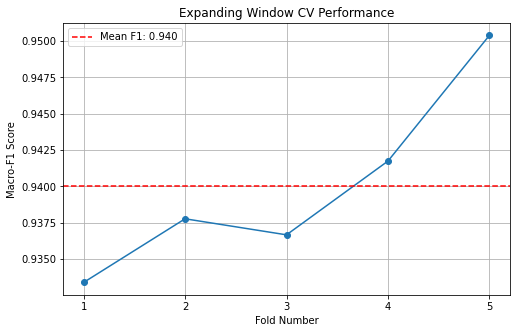

In [76]:
plt.figure(figsize = (8, 5))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker = 'o', linestyle = '-')

plt.xlabel("Fold Number")
plt.ylabel("Macro-F1 Score")
plt.title("Expanding Window CV Performance")
plt.xticks(range(1, len(cv_scores) + 1))
plt.grid(True)

plt.axhline(y = np.mean(cv_scores), color = 'r', linestyle = '--', label = f"Mean F1: {np.mean(cv_scores):.3f}")
plt.legend()
plt.show()

Prediction on the holdout set yields a macro f1 socre of 0.89.

In [77]:
# Predict on final validation set
y_validation_pred = lr.predict(X_validation)

# Evaluate final performance
print("Final Validation on Last 2 Days (50 Tickers)")
print("Classification Report:")
print(classification_report(y_validation, y_validation_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_validation, y_validation_pred))

Final Validation on Last 2 Days (50 Tickers)
Classification Report:
                         precision    recall  f1-score   support

              Decreased       0.75      1.00      0.86         6
              Increased       0.90      0.75      0.82        12
                Neutral       1.00      0.88      0.94        25
Significantly Decreased       1.00      1.00      1.00         3
Significantly Increased       0.73      1.00      0.84         8

               accuracy                           0.89        54
              macro avg       0.88      0.93      0.89        54
           weighted avg       0.91      0.89      0.89        54

Confusion Matrix:
[[ 6  0  0  0  0]
 [ 0  9  0  0  3]
 [ 2  1 22  0  0]
 [ 0  0  0  3  0]
 [ 0  0  0  0  8]]


### MLP

The MLP model has a Mean Expanding Window CV Macro-F1 Score: 0.85.

In [78]:
cv_scores = []

for fold_idx, (train_start, train_end, test_start, test_end) in enumerate(folds):
    train_dates = unique_dates[train_start:train_end]  # Training range
    test_dates = unique_dates[test_start:test_end]  # Testing range

    # Create masks to filter data
    train_mask = df_modeling["Date"].isin(train_dates)
    test_mask = df_modeling["Date"].isin(test_dates)

    # Apply masks before extracting features
    X_train = df_modeling.loc[train_mask].drop(["Trend", "Date", "Ticker"], axis = 1).reset_index(drop = True)
    y_train = df_modeling.loc[train_mask]["Trend"].reset_index(drop = True)

    X_test = df_modeling.loc[test_mask].drop(["Trend", "Date", "Ticker"], axis = 1).reset_index(drop = True)
    y_test = df_modeling.loc[test_mask]["Trend"].reset_index(drop = True)

    # Convert embeddings
    if "Aggregated_Embeddings" in X_train.columns and not X_train["Aggregated_Embeddings"].isna().all():
        X_embeddings_train = np.stack(X_train["Aggregated_Embeddings"])
        X_train = pd.concat([X_train.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                             pd.DataFrame(X_embeddings_train)], axis = 1)

    if "Aggregated_Embeddings" in X_test.columns and not X_test["Aggregated_Embeddings"].isna().all():
        X_embeddings_test = np.stack(X_test["Aggregated_Embeddings"])
        X_test = pd.concat([X_test.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                            pd.DataFrame(X_embeddings_test)], axis = 1)

    # Ensure only numeric columns
    X_train = X_train.select_dtypes(include = [np.number])
    X_train.columns = X_train.columns.astype(str)

    X_test = X_test.select_dtypes(include = [np.number])
    X_test.columns = X_test.columns.astype(str)

    # Apply SMOTE to balance training data
    # smote = SMOTE(random_state = 42)
    # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    # Print class distribution after SMOTE
    # unique, counts = np.unique(y_train_resampled, return_counts = True)
    # print(f"Class distribution after SMOTE for Fold {fold_idx + 1}: {dict(zip(unique, counts))}")

    # Define and train MLP model
    mlp = MLPClassifier(hidden_layer_sizes = (100,), activation = "relu", solver = "adam", 
                        max_iter = 500, random_state = 42)
    mlp.fit(X_train, y_train)

    # Evaluate model
    y_pred = mlp.predict(X_test)
    f1 = f1_score(y_test, y_pred, average = "macro")
    cv_scores.append(f1)

    print(f"Results for Fold {fold_idx + 1}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("------------------------------------------------------------")

print("Expanding Window CV Macro-F1 Scores:", cv_scores)
print("Mean Expanding Window CV Macro-F1 Score:", np.mean(cv_scores))

Results for Fold 1:
Classification Report:
                         precision    recall  f1-score   support

              Decreased       0.92      0.89      0.91        55
              Increased       0.59      0.31      0.40       220
                Neutral       0.67      1.00      0.80       300
Significantly Decreased       0.90      0.69      0.78        13
Significantly Increased       0.87      0.49      0.63        94

               accuracy                           0.69       682
              macro avg       0.79      0.68      0.70       682
           weighted avg       0.69      0.69      0.66       682

Confusion Matrix:
[[ 49   0   5   1   0]
 [  0  68 145   0   7]
 [  0   0 300   0   0]
 [  4   0   0   9   0]
 [  0  48   0   0  46]]
------------------------------------------------------------
Results for Fold 2:
Classification Report:
                         precision    recall  f1-score   support

              Decreased       0.98      0.87      0.92        47


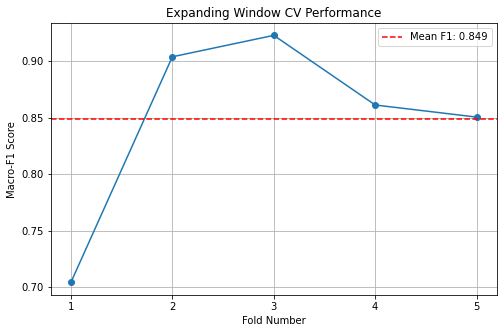

In [80]:
plt.figure(figsize = (8, 5))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker = 'o', linestyle = '-')

plt.xlabel("Fold Number")
plt.ylabel("Macro-F1 Score")
plt.title("Expanding Window CV Performance")
plt.xticks(range(1, len(cv_scores) + 1))
plt.grid(True)

plt.axhline(y = np.mean(cv_scores), color = 'r', linestyle = '--', label = f"Mean F1: {np.mean(cv_scores):.3f}")
plt.legend()
plt.show()

Prediction on the holdout set yields a macro f1 socre of 0.78.

In [81]:
# Predict on final validation set
y_validation_pred = mlp.predict(X_validation)

# Evaluate final performance
print("Final Validation on Last 2 Days (50 Tickers)")
print("Classification Report:")
print(classification_report(y_validation, y_validation_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_validation, y_validation_pred))

Final Validation on Last 2 Days (50 Tickers)
Classification Report:
                         precision    recall  f1-score   support

              Decreased       0.40      1.00      0.57         6
              Increased       1.00      0.75      0.86        12
                Neutral       0.94      0.68      0.79        25
Significantly Decreased       1.00      0.67      0.80         3
Significantly Increased       0.80      1.00      0.89         8

               accuracy                           0.78        54
              macro avg       0.83      0.82      0.78        54
           weighted avg       0.88      0.78      0.80        54

Confusion Matrix:
[[ 6  0  0  0  0]
 [ 0  9  1  0  2]
 [ 8  0 17  0  0]
 [ 1  0  0  2  0]
 [ 0  0  0  0  8]]


### Ramdom Forest

The random forest model has a Mean Expanding Window CV Macro-F1 Score: 0.85.

In [82]:
cv_scores = []

for fold_idx, (train_start, train_end, test_start, test_end) in enumerate(folds):
    train_dates = unique_dates[train_start:train_end]  # Training range
    test_dates = unique_dates[test_start:test_end]  # Testing range

    # Create masks to filter data
    train_mask = df_modeling["Date"].isin(train_dates)
    test_mask = df_modeling["Date"].isin(test_dates)

    # Apply masks before extracting features
    X_train = df_modeling.loc[train_mask].drop(["Trend", "Date", "Ticker"], axis = 1).reset_index(drop = True)
    y_train = df_modeling.loc[train_mask]["Trend"].reset_index(drop = True)

    X_test = df_modeling.loc[test_mask].drop(["Trend", "Date", "Ticker"], axis = 1).reset_index(drop = True)
    y_test = df_modeling.loc[test_mask]["Trend"].reset_index(drop = True)

    # Convert embeddings if applicable
    if "Aggregated_Embeddings" in X_train.columns and not X_train["Aggregated_Embeddings"].isna().all():
        X_embeddings_train = np.stack(X_train["Aggregated_Embeddings"])
        X_train = pd.concat([X_train.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                             pd.DataFrame(X_embeddings_train)], axis = 1)

    if "Aggregated_Embeddings" in X_test.columns and not X_test["Aggregated_Embeddings"].isna().all():
        X_embeddings_test = np.stack(X_test["Aggregated_Embeddings"])
        X_test = pd.concat([X_test.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                            pd.DataFrame(X_embeddings_test)], axis = 1)

    # Ensure only numeric columns
    X_train = X_train.select_dtypes(include = [np.number])
    X_train.columns = X_train.columns.astype(str)

    X_test = X_test.select_dtypes(include = [np.number])
    X_test.columns = X_test.columns.astype(str)

    # Apply SMOTE to balance training data
    # smote = SMOTE(random_state = 42)
    # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    # Print class distribution after SMOTE
    # unique, counts = np.unique(y_train_resampled, return_counts = True)
    # print(f"Class distribution after SMOTE for Fold {fold_idx + 1}: {dict(zip(unique, counts))}")

    # Define Random Forest with Hyperparameter Tuning
    rf = RandomForestClassifier(random_state = 42)
    param_dist = {"n_estimators": [100, 200, 300, 500],           
                  "max_depth": [10, 20, 30, None],      
                  "min_samples_split": [2, 5, 10],            
                  "min_samples_leaf": [1, 2, 4],             
                  "max_features": ["sqrt", "log2"],        # Number of features considered for splits
                  "class_weight": ["balanced", None]}    

    random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, n_iter = 50,
                                       scoring = "f1_macro", cv = 5, verbose = 2, random_state = 42,
                                       n_jobs = -1)

    random_search.fit(X_train, y_train)
    best_rf = random_search.best_estimator_

    # Evaluate model
    y_pred = best_rf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average = "macro")
    cv_scores.append(f1)

    print(f"Results for Fold {fold_idx + 1}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("------------------------------------------------------------")

print("Expanding Window CV Macro-F1 Scores:", cv_scores)
print("Mean Expanding Window CV Macro-F1 Score:", np.mean(cv_scores))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Results for Fold 1:
Classification Report:
                         precision    recall  f1-score   support

              Decreased       0.95      0.95      0.95        55
              Increased       0.77      0.80      0.78       220
                Neutral       0.85      1.00      0.92       300
Significantly Decreased       0.92      0.85      0.88        13
Significantly Increased       1.00      0.35      0.52        94

               accuracy                           0.84       682
              macro avg       0.90      0.79      0.81       682
           weighted avg       0.85      0.84      0.82       682

Confusion Matrix:
[[ 52   0   2   1   0]
 [  0 176  44   0   0]
 [  1   0 299   0   0]
 [  2   0   0  11   0]
 [  0  53   8   0  33]]
------------------------------------------------------------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Results for Fold 2:
Classification Report:
       

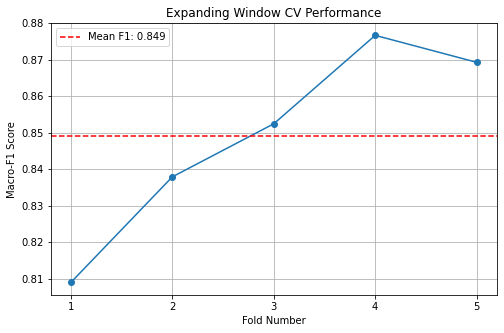

In [84]:
plt.figure(figsize = (8, 5))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker = 'o', linestyle = '-')

plt.xlabel("Fold Number")
plt.ylabel("Macro-F1 Score")
plt.title("Expanding Window CV Performance")
plt.xticks(range(1, len(cv_scores) + 1))
plt.grid(True)

plt.axhline(y = np.mean(cv_scores), color = 'r', linestyle = '--', label = f"Mean F1: {np.mean(cv_scores):.3f}")
plt.legend()
plt.show()

Prediction on the holdout set yields a macro f1 socre of 0.91.

In [83]:
# Predict on final validation set
y_validation_pred = best_rf.predict(X_validation)

# Evaluate final performance
print("Final Validation on Last 2 Days (50 Tickers)")
print("Classification Report:")
print(classification_report(y_validation, y_validation_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_validation, y_validation_pred))

Final Validation on Last 2 Days (50 Tickers)
Classification Report:
                         precision    recall  f1-score   support

              Decreased       0.83      0.83      0.83         6
              Increased       1.00      0.92      0.96        12
                Neutral       0.93      1.00      0.96        25
Significantly Decreased       1.00      0.67      0.80         3
Significantly Increased       1.00      1.00      1.00         8

               accuracy                           0.94        54
              macro avg       0.95      0.88      0.91        54
           weighted avg       0.95      0.94      0.94        54

Confusion Matrix:
[[ 5  0  1  0  0]
 [ 0 11  1  0  0]
 [ 0  0 25  0  0]
 [ 1  0  0  2  0]
 [ 0  0  0  0  8]]


### XGBoost

The dataset might be too easy for XGBoost. Even after applying techniques to mitigate overfitting, the XGBoost model still has a Mean Expanding Window CV Macro-F1 Score: 0.95.

In [80]:
!pip uninstall -y scikit-learn
!pip install scikit-learn == 1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-macosx_12_0_arm64.whl (11.0 MB)


In [85]:
cv_scores = []

for fold_idx, (train_start, train_end, test_start, test_end) in enumerate(folds):
    train_dates = unique_dates[train_start:train_end]  # Training range
    test_dates = unique_dates[test_start:test_end]  # Testing range

    # Create masks to filter data
    train_mask = df_modeling["Date"].isin(train_dates)
    test_mask = df_modeling["Date"].isin(test_dates)

    # Apply masks before extracting features
    X_train = df_modeling.loc[train_mask].drop(["Trend", "Date", "Ticker"], axis = 1).reset_index(drop = True)
    y_train = df_modeling.loc[train_mask]["Trend"].reset_index(drop = True)

    X_test = df_modeling.loc[test_mask].drop(["Trend", "Date", "Ticker"], axis = 1).reset_index(drop = True)
    y_test = df_modeling.loc[test_mask]["Trend"].reset_index(drop = True)

    # Convert embeddings
    if "Aggregated_Embeddings" in X_train.columns and not X_train["Aggregated_Embeddings"].isna().all():
        X_embeddings_train = np.stack(X_train["Aggregated_Embeddings"])
        X_train = pd.concat([X_train.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                             pd.DataFrame(X_embeddings_train)], axis = 1)

    if "Aggregated_Embeddings" in X_test.columns and not X_test["Aggregated_Embeddings"].isna().all():
        X_embeddings_test = np.stack(X_test["Aggregated_Embeddings"])
        X_test = pd.concat([X_test.drop(["Aggregated_Embeddings"], axis = 1).reset_index(drop = True),
                            pd.DataFrame(X_embeddings_test)], axis = 1)

    # Ensure only numeric columns
    X_train = X_train.select_dtypes(include = [np.number])
    X_train.columns = X_train.columns.astype(str)

    X_test = X_test.select_dtypes(include = [np.number])
    X_test.columns = X_test.columns.astype(str)

    # Apply SMOTE to balance training data
    # smote = SMOTE(random_state = 42)
    # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    # Print class distribution after SMOTE
    # unique, counts = np.unique(y_train_resampled, return_counts = True)
    # print(f"Class distribution after SMOTE for Fold {fold_idx + 1}: {dict(zip(unique, counts))}")

    # Encode y_train_resampled and y_test for evaluation consistency
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)
    
    # Reduce Overfitting in XGBoost
    xgb = XGBClassifier(random_state = 42, n_estimators = 50, max_depth = 3, learning_rate = 0.05,
                        subsample = 0.5, colsample_bytree = 0.6, reg_alpha = 10.0, reg_lambda = 50.0,
                        gamma = 5.0, eval_metric = "mlogloss", use_label_encoder = False)
    xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds = 10, verbose = False)

    # Evaluate model
    y_pred = xgb.predict(X_test)
    f1 = f1_score(y_test, y_pred, average = "macro")
    cv_scores.append(f1)

    print(f"Results for Fold {fold_idx + 1}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("------------------------------------------------------------")

print("Expanding Window CV Macro-F1 Scores:", cv_scores)
print("Mean Expanding Window CV Macro-F1 Score:", np.mean(cv_scores))

Results for Fold 1:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00       220
           2       0.76      1.00      0.86       300
           3       1.00      1.00      1.00        13
           4       0.00      0.00      0.00        94

    accuracy                           0.86       682
   macro avg       0.75      0.80      0.77       682
weighted avg       0.76      0.86      0.80       682

Confusion Matrix:
[[ 55   0   0   0   0]
 [  0 220   0   0   0]
 [  0   1 299   0   0]
 [  0   0   0  13   0]
 [  0   0  94   0   0]]
------------------------------------------------------------
Results for Fold 2:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00       212
           2       1.00      1.00      1.00       335
           3 

In [86]:
# Predict on final validation set
y_validation_pred = xgb.predict(X_validation)
y_validation_pred_labels = le.inverse_transform(y_validation_pred)

# Evaluate final performance
print("Final Validation on Last 2 Days (50 Tickers)")
print("Final Validation Classification Report:")
print(classification_report(y_validation, y_validation_pred_labels))
print("Final Validation Confusion Matrix:")
print(confusion_matrix(y_validation, y_validation_pred_labels))

Final Validation on Last 2 Days (50 Tickers)
Final Validation Classification Report:
                         precision    recall  f1-score   support

              Decreased       1.00      1.00      1.00         6
              Increased       1.00      1.00      1.00        12
                Neutral       1.00      1.00      1.00        25
Significantly Decreased       1.00      1.00      1.00         3
Significantly Increased       1.00      1.00      1.00         8

               accuracy                           1.00        54
              macro avg       1.00      1.00      1.00        54
           weighted avg       1.00      1.00      1.00        54

Final Validation Confusion Matrix:
[[ 6  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 25  0  0]
 [ 0  0  0  3  0]
 [ 0  0  0  0  8]]
